In [1]:
import numpy as np
import pointMass
import gym

from SAC import *
import pickle
from pytorch_shared import *
import torch

In [2]:
filepath= 'collected_data/125750HER2_pointMassObjectDuo-v0_Hidden_256l_2.npz'
data = np.load(filepath)
test_env = gym.make('pointMassObjectDuo-v0')
env = test_env
render = True
# pybullet nees the GUI env to be reset first for our noncollision stuff to work.
if render:
    print('Rendering Test Rollouts')
    test_env.render(mode='human')
    test_env.reset()

seeding
Environment set to sparse reward
Rendering Test Rollouts


In [3]:
obs = np.concatenate([data['obs'], data['desired_goals']], axis=-1)
acts = data['acts']

print(obs.shape)

(503, 250, 16)


In [6]:
import time

for j in range(0, len(obs)):
    ep = obs[j]
    ep_acts = acts[j]
    o  = ep[0]
    env.initialize_start_pos(o)
    env.reset_goal_pos(o[-4:])
    for i in range(0, len(ep)):
        env.step(ep_acts[i])
        #time.sleep(0.005)
        #env.visualise_sub_goal(o[:2]+a, lower_achieved_whole_state=True)
    

KeyboardInterrupt: 

In [12]:
env.reset_goal_pos(o[-2:])

IndexError: index 2 is out of bounds for axis 0 with size 2

In [8]:
from torch.distributions import Normal
m = Normal(torch.tensor([0.0, 0.0]), torch.tensor([1.0, 0.5]))
m = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
m.sample()

tensor([0.1647])

In [14]:
m.cdf(0.5)

tensor([0.6915])

In [16]:
m.pdf(torch.as_tensor(np.linspace(0,1,10), dtype=torch.float32))

AttributeError: 'Normal' object has no attribute 'pdf'

In [1]:
import numpy as np
import pointMass
import gym

from SAC import *
import pickle
from pytorch_shared import *
import torch

In [2]:
# with open('collected_data/filename.pickle', 'rb') as handle:
#     replay_higher = pickle.load(handle)



In [8]:
#exp_name = "hierarchial2_pointMass-v0_Hidden_256l_2"
env_name = 'pointMassObject-v0'

exp_name = "hierarchial2_"+env_name+"_Hidden_256l_2"
with open('collected_data/' + exp_name + 'rbuf.pickle', 'rb') as handle:
    replay_higher = pickle.load(handle)
    
exp_name = "hierarchial2_no_subgoaltest_pointMassObject-v0_Hidden_256l_2"

seed = 0
render = True
print('Begin')
tf.random.set_seed(seed)
np.random.seed(seed)


Begin


In [3]:
test_env = gym.make(env_name)
env = test_env
# pybullet nees the GUI env to be reset first for our noncollision stuff to work.
if render:
    print('Rendering Test Rollouts')
    test_env.render(mode='human')
    test_env.reset()

seeding
Environment set to sparse reward
Rendering Test Rollouts


In [9]:


# Little bit of short term conif
use_higher_level = True
lower_achieved_state = 'controllable_achieved_goal'  #  'full_positional_state' # 'achieved_goal' # 
substitute_action = True


# Get Env dimensions for networks
obs_dim_higher = env.observation_space.spaces['observation'].shape[0] + env.observation_space.spaces['desired_goal'].shape[0]
# now, our action can either be the  full state, or just the controllable aspects.
act_dim_higher = env.observation_space.spaces[lower_achieved_state].shape[0]

if use_higher_level:
    obs_dim_lower = env.observation_space.spaces['observation'].shape[0] + act_dim_higher
else:
    obs_dim_lower = env.observation_space.spaces['observation'].shape[0] + env.observation_space.spaces['desired_goal'].shape[0]

act_dim_lower = env.action_space.shape[0]

# higher level model
gamma=0.99,
polyak=0.995
lr=1e-3
alpha=0.2
load  = True
relative = False
act_limit_higher = env.ENVIRONMENT_BOUNDS
SAC_higher = SAC_model(act_limit_higher, obs_dim_higher, act_dim_higher, [256,256], lr, gamma, alpha, polyak, load, exp_name+'_higher')
act_limit_lower = env.action_space.high[0]
SAC_lower = SAC_model(act_limit_lower, obs_dim_lower, act_dim_lower, [256,256], lr, gamma, alpha, polyak, load, exp_name+'_lower')

Successfully loaded

Number of parameters: 	 pi: 69636, 	 q1: 69377, 	 q2: 69377

Successfully loaded

Number of parameters: 	 pi: 69636, 	 q1: 69377, 	 q2: 69377



In [5]:
def get_transition(replay_buffer, index):
    
    o1 = replay_buffer.obs1_buf[index]
    o2 =  replay_buffer.obs2_buf[index]
    a = replay_buffer.acts_buf[index]
    r = replay_buffer.rews_buf[index]
    return o1, o2, a, r
    

In [7]:
len(replay_higher.obs1_buf)

1000000

In [6]:
import time
import matplotlib.pyplot as plt

def plot_heatmap(X,Y,Z):
    mesh = plt.pcolormesh(X,Y,Z)
    cb = plt.colorbar()
    plt.scatter(o[0], o[1], marker = 'x')
    plt.scatter(o[-2], o[-1])
    arr = mesh.get_array().reshape(mesh._meshWidth, mesh._meshHeight)
    plt.imshow(arr.T, origin = 'lower', extent = [0, size, 0, size], alpha=0.8)
    plt.show()
    

# simple for when using achieved goal with a single achieved goal in pm or pmO
def heatmap_q(o, size, relative = True):
    a  =np.linspace(-env.ENVIRONMENT_BOUNDS,env.ENVIRONMENT_BOUNDS,80)
    r = []
    for i in  list(a):
        for j in  list(a):
            r.append([i,j])
    tiled_os  = np.tile(np.expand_dims(o,0),[len(r),1])
    options = np.array(r)
    
    if relative:
        options = options - tiled_os[:,0:2]
    
    tiled_os = torch.as_tensor(tiled_os, dtype=torch.float32).cuda()
    options = torch.as_tensor(options, dtype=torch.float32).cuda()
    q_vals = SAC_higher.ac.q1(tiled_os, options).cpu().detach().numpy()

    if relative:
        options = options + tiled_os[:,0:2]
                  
    options = (options).cpu().detach().numpy()
    X = options[:,0].reshape(len(a),len(a))  #(np.meshgrid(a,a)
    Y = options[:,1].reshape(len(a),len(a))
    #X, Y = np.meshgrid(a,a)

    Z=q_vals.reshape(len(a),len(a))
    plot_heatmap(X,Y,Z)

    
# more complex, pmO with full state of self and obj
def heatmap_q_object(o, size, object_q= False):
    
    a  =np.linspace(-env.ENVIRONMENT_BOUNDS,env.ENVIRONMENT_BOUNDS,80)
    r = []
    for i in  list(a):
        for j in  list(a):
            r.append([i,j])
    tiled_os  = np.tile(np.expand_dims(o,0),[len(r),1])
    options = np.array(r)
    if object_q:
        options = options - tiled_os[:,4:6]
        options = np.concatenate([np.zeros(options.shape), options],axis = 1)
    else:
        options = options - tiled_os[:,0:2]
        options = np.concatenate([options, np.zeros(options.shape)],axis = 1)

    tiled_os = torch.as_tensor(tiled_os, dtype=torch.float32).cuda()
    options = torch.as_tensor(options, dtype=torch.float32).cuda()
    q_vals = SAC_higher.ac.q1(tiled_os, options).cpu().detach().numpy()

    tiled_os = tiled_os.cpu().detach().numpy()
    options = (options).cpu().detach().numpy()

    if object_q:
        options =  options + np.concatenate([np.zeros(tiled_os[:,4:6].shape), tiled_os[:,4:6]],axis = 1)  
        X = options[:,2].reshape(len(a),len(a))  #(np.meshgrid(a,a)
        Y = options[:,3].reshape(len(a),len(a))
    else:
        options = options +  np.concatenate([tiled_os[:,4:6], np.zeros(tiled_os[:,4:6].shape)],axis = 1)  
        X = options[:,0].reshape(len(a),len(a))  #(np.meshgrid(a,a)
        Y = options[:,1].reshape(len(a),len(a))

    #X, Y = np.meshgrid(a,a)
    Z=q_vals.reshape(len(a),len(a))
    plot_heatmap(X,Y,Z)
    


#157,180
633,650


(633, 650)

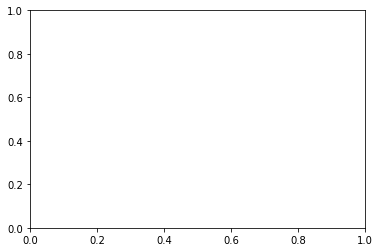

In [12]:

from IPython.display import display, clear_output
fig, ax = plt.subplots()

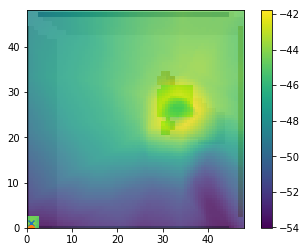

In [9]:


n = 300000
for i in range(n, n+200, 5):
    o, o2, a, r = get_transition(replay_higher, i) # 5 because each step 4 goals are added for HER
    env.initialize_start_pos(o)
    print(a)
    if 'Object' in exp_name and lower_achieved_state == 'full_positional_state':
        
        if relative:
            sub_goal = np.concatenate([o[0:2]+a[0:2], o[4:6]+a[2:4]])
            env.visualise_sub_goal(np.concatenate([o[0:2]+a[0:2], o[4:6]+a[2:4]]), sub_goal_state=lower_achieved_state)
        else:
            env.visualise_sub_goal(a, sub_goal_state=lower_achieved_state)
            
    else:
        if relative:
            env.visualise_sub_goal(o[:2]+a, sub_goal_state=lower_achieved_state)
        else:
            env.visualise_sub_goal(a, sub_goal_state=lower_achieved_state)
    env.reset_goal_pos(o2[-2:])
    
    
    
    clear_output(wait=True)
    image = env.calc_state()['image']
    size = image.shape[0]
    plt.imshow(np.flip(image,0), origin = 'lower')
    
    if 'Object' in exp_name:
        if lower_achieved_state == 'full_positional_state':
            heatmap_q_object(o,size, object_q = True)
        else:
            heatmap_q(o,size, relative)
    else:
        heatmap_q(o,size, relative)

    #heatmap_v(o2, size)
    #display(fig)
    
    #print(SAC_higher.value(np.expand_dims(o,0)).numpy()[0][0])


In [18]:
# how about instead we just watch it do a thing?
from hierarchy import *
replan_interval = 10
max_ep_len = 150
episodes = rollout_trajectories_hierarchially(n_steps = max_ep_len, env = env, max_ep_len = max_ep_len,
                                actor_lower = SAC_lower.actor.get_deterministic_action,
                                actor_higher = SAC_higher.actor.get_deterministic_action, relative = relative, replan_interval = replan_interval,
                                lower_achieved_state = lower_achieved_state,
                                substitute_action = False, use_higher_level = True, train=False, render=True,
                                current_total_steps = 0,
                                exp_name = exp_name, return_episode = True, exp_replay_buffer = replay_higher)

Test Frame:  149  Return:  -150


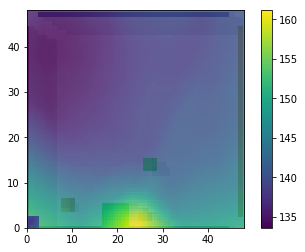

In [21]:
time.sleep(1)
for d in episodes['episodes_higher'][0]:
    f = d[0]
    a = d[1]
    o = np.concatenate([f['observation'], f['desired_goal']])
    #time.sleep(0.25)
    env.initialize_start_pos(o)
    env.visualise_sub_goal(a, sub_goal_state=lower_achieved_state)
    clear_output(wait=True)
    image = env.calc_state()['image']
    size = image.shape[0]
    plt.imshow(np.flip(image,0), origin = 'lower')
    heatmap_q(o,size, relative)


In [28]:
episodes['episodes_higher'][0][0][1]

array([0.1430771, 1.588052 ], dtype=float32)

In [12]:

env = gym.make('pointMass-v0')
obs_dim = env.observation_space.spaces['observation'].shape[0] + env.observation_space.spaces['desired_goal'].shape[0]
act_dim, act_limit = env.action_space.shape[0], env.action_space.high[0]
model = SAC_model(act_limit, obs_dim, act_dim, ac_kwargs['hidden_sizes'],lr, gamma, alpha, polyak,  load, exp_name)
policy = SquashedGaussianMLPActor(obs_dim, act_dim, hidden_sizes=[256,256], act_limit=1).cuda()
torch.load('saved_models/_SAC_HER2_pointMass-v0_Hidden_256l_2.pth')

seeding
Environment set to sparse reward


NameError: name 'ac_kwargs' is not defined

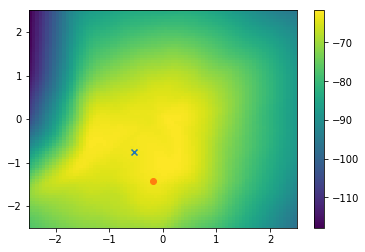

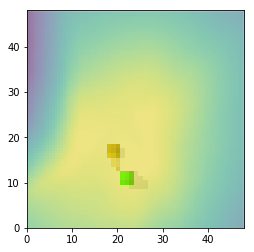

In [167]:
o, o2, a, r = get_transition(replay_higher, 805)
env.initialize_start_pos(o)
env.visualise_sub_goal(o[:2]+a, lower_achieved_whole_state=True)
env.reset_goal_pos(o2[-2:])

a  =np.linspace(-env.ENVIRONMENT_BOUNDS,env.ENVIRONMENT_BOUNDS,80)
r = []
for i in  list(a):
    for j in  list(a):
        r.append([i,j])
tiled_os  = np.tile(np.expand_dims(o,0),[len(r),1])
options = np.array(r)
options = options - tiled_os[:,0:2]
q_vals = SAC_higher.q_func2(np.concatenate([tiled_os, options], axis = 1)).numpy()

options = options + tiled_os[:,0:2]
X = options[:,0].reshape(len(a),len(a))  #(np.meshgrid(a,a)
Y = options[:,1].reshape(len(a),len(a))
#X, Y = np.meshgrid(a,a)

Z=q_vals.reshape(len(a),len(a))



mesh = plt.pcolormesh(X,Y,Z)
cb = plt.colorbar()
plt.scatter(o[0], o[1], marker = 'x')
plt.scatter(o[-2], o[-1])
plt.show()
image = env.calc_state()['image']
size = image.shape[0]
arr = mesh.get_array().reshape(mesh._meshWidth, mesh._meshHeight)
plt.imshow(np.flip(image,0), origin = 'lower')
plt.imshow(arr.T, origin = 'lower', extent = [0, size, 0, size], alpha=0.5)

plt.show()



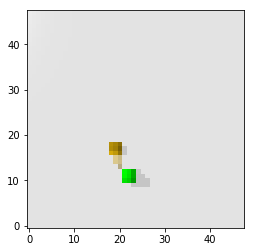

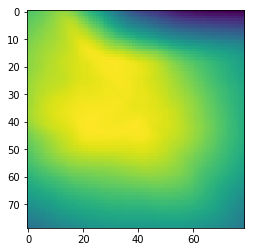

In [131]:
plt.imshow(arr)

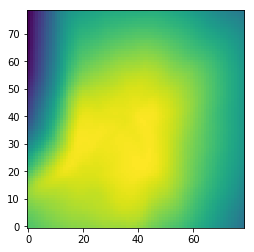

In [110]:
plt.imshow(arr, origin = 'lower')

array([[ -85.081154,  -84.70857 ,  -84.32212 , ..., -124.58891 ,
        -124.52762 , -124.55964 ],
       [ -84.63714 ,  -84.22004 ,  -83.83444 , ..., -122.072845,
        -122.120705, -122.08097 ],
       [ -84.15713 ,  -83.75156 ,  -83.35167 , ..., -119.67857 ,
        -119.68497 , -119.64608 ],
       ...,
       [-106.962524, -106.67987 , -106.418755, ...,  -86.99319 ,
         -87.27194 ,  -87.55054 ],
       [-107.96132 , -107.70021 , -107.43912 , ...,  -87.691444,
         -87.97953 ,  -88.25689 ],
       [-108.9817  , -108.70877 , -108.43132 , ...,  -88.42115 ,
         -88.682884,  -88.96589 ]], dtype=float32)

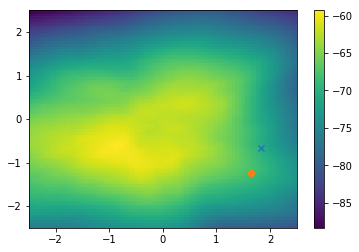

In [144]:
def heatmap_v(o, size):
    a  =np.linspace(-env.ENVIRONMENT_BOUNDS,env.ENVIRONMENT_BOUNDS,80)
    r = []
    for i in  list(a):
        for j in  list(a):
            r.append([i,j])
    tiled_os  = np.tile(np.expand_dims(o,0),[len(r),1])
    options = np.array(r)
    tiled_os[:,0:2] = options
    v_vals = SAC_higher.value(tiled_os).numpy()


    X, Y = np.meshgrid(a,a)

    Z=v_vals.reshape(len(a),len(a))

    mesh  = plt.pcolormesh(X,Y,Z)
    cb = plt.colorbar()
    plt.scatter(o[0], o[1], marker = 'x')
    plt.scatter(o[-2], o[-1])
    arr = mesh.get_array().reshape(mesh._meshWidth, mesh._meshHeight)
    plt.imshow(arr, origin = 'lower', extent = [0, size, 0, size], alpha=0.8)
    plt.show()
    

In [1]:
import numpy as np
import multiprocessing as mp

In [2]:
def np_mp_array(shape, dtype):
    """Allocate a numpy array on OS shared memory."""
    size = int(np.prod(shape))
    nbytes = size * np.dtype(dtype).itemsize
    mp_array = mp.RawArray(ctypes.c_char, nbytes)
    return np.frombuffer(mp_array, dtype=dtype, count=size).reshape(shape)

In [1]:
import numpy as np

class SumTree(object):
    data_pointer = 0
    
    # Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    def __init__(self, capacity):
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema below
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)
    
    
    # Here we define function that will add our priority score in the sumtree leaf and add the experience in data:
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1

        # Update data frame
        self.data[self.data_pointer] = data

        # Update the leaf
        self.update (tree_index, priority)

        # Add 1 to data_pointer
        self.data_pointer += 1

        if self.data_pointer >= self.capacity:  # If we're above the capacity, we go back to first index (we overwrite)
            self.data_pointer = 0
            
    # Update the leaf priority score and propagate the change through tree
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority

        # then propagate the change through tree
        # this method is faster than the recursive loop in the reference code
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
        
    # Here build a function to get a leaf from our tree. So we'll build a function to get the leaf_index, priority value of that leaf and experience associated with that leaf index:
    def get_leaf(self, v):
        parent_index = 0

        # the while loop is faster than the method in the reference code
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else: # downward search, always search for a higher priority node
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node

# Now we finished constructing our SumTree object, next we'll build a memory object.
class Memory(object):  # stored as ( state, action, reward, next_state ) in SumTree
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4  # importance-sampling, from initial value increasing to 1
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        # Making the tree 
        self.tree = SumTree(capacity)
        
    # Next, we define a function to store a new experience in our tree.
    # Each new experience will have a score of max_prority (it will be then improved when we use this exp to train our DDQN).
    def store(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])

        # If the max priority = 0 we can't put priority = 0 since this experience will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper

        self.tree.add(max_priority, experience)   # set the max priority for new priority
        
    # Now we create sample function, which will be used to pick batch from our tree memory, which will be used to train our model.
    # - First, we sample a minibatch of n size, the range [0, priority_total] into priority ranges.
    # - Then a value is uniformly sampled from each range.
    # - Then we search in the sumtree, for the experience where priority score correspond to sample values are retrieved from.
    def sample(self, n):
        # Create a minibatch array that will contains the minibatch
        minibatch = []

        b_idx = np.empty((n,), dtype=np.int32)

        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n       # priority segment

        for i in range(n):
            # A value is uniformly sample from each range
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)

            # Experience that correspond to each value is retrieved
            index, priority, data = self.tree.get_leaf(value)
            print(index, priority, data)
            b_idx[i]= index

            # if we are storing full data
            # minibatch.append([data[0],data[1],data[2],data[3],data[4]])
            # if just storing primary index
            minibatch.append(data)

        return b_idx, minibatch
    
    # Update the priorities on the tree
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)


In [8]:
memory_size = 5
buffer = Memory(memory_size)

for i in range(0,5):
    buffer.store(i)
    
tree_idxs, indexes = buffer.sample(2)
print(tree_idxs, indexes)


buffer.batch_update(tree_idxs, np.random.rand(32))
buffer.batch_update([7,6], np.array([1000,0.01]))
buffer.batch_update([4,5,7,8], np.array([0.001,0.001,0.001,0.001]))

8 1.0 4
5 1.0 1
[8 5] [4, 1]


In [17]:
buffer.batch_update([7,6], np.array([7,-0.01]))

In [32]:
tree_idxs, indexes = buffer.sample(2)

8 1.0 4
5 1.0 1


In [13]:
for i in range(0,5):
    buffer.store(i)

In [112]:

print(tree_idxs, indexes)

7 0.06680909842748059 3
6 0.0956352499790037 2
[7 6] [3, 2]


In [47]:
buffer.batch_update(tree_idxs, np.random.rand(32))

In [67]:
buffer.batch_update([7,6], np.array([1000,0.01]))

In [98]:
buffer.batch_update([4,5,7,8], np.array([0.001,0.001,0.001,0.001]))

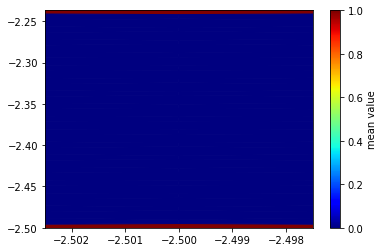

In [116]:
x = options[0,:]
y =options[1,:]
PLT.hexbin(x,y , C=None, gridsize=gridsize, cmap=CM.jet, bins=None)
PLT.axis([x.min(), x.max(), y.min(), y.max()])

cb = PLT.colorbar()
cb.set_label('mean value')
PLT.show()  

/home/sholto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  if __name__ == '__main__':
/home/sholto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  # Remove the CWD from sys.path while we load stuff.


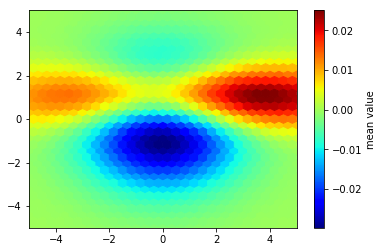

In [97]:
from matplotlib import pyplot as PLT
from matplotlib import cm as CM
from matplotlib import mlab as ML
import numpy as NP
%matplotlib inline
n = 1e5
x = y = NP.linspace(-5, 5, 100)
X, Y = NP.meshgrid(x, y)
Z1 = ML.bivariate_normal(X, Y, 2, 2, 0, 0)
Z2 = ML.bivariate_normal(X, Y, 4, 1, 1, 1)
ZD = Z2 - Z1
x = X.ravel()
y = Y.ravel()
z = ZD.ravel()
gridsize=30
PLT.subplot(111)

# if 'bins=None', then color of each hexagon corresponds directly to its count
# 'C' is optional--it maps values to x-y coordinates; if 'C' is None (default) then 
# the result is a pure 2D histogram 

 

array([-5.        , -4.8989899 , -4.7979798 , -4.6969697 , -4.5959596 ,
       -4.49494949, -4.39393939, -4.29292929, -4.19191919, -4.09090909,
       -3.98989899, -3.88888889, -3.78787879, -3.68686869, -3.58585859,
       -3.48484848, -3.38383838, -3.28282828, -3.18181818, -3.08080808,
       -2.97979798, -2.87878788, -2.77777778, -2.67676768, -2.57575758,
       -2.47474747, -2.37373737, -2.27272727, -2.17171717, -2.07070707,
       -1.96969697, -1.86868687, -1.76767677, -1.66666667, -1.56565657,
       -1.46464646, -1.36363636, -1.26262626, -1.16161616, -1.06060606,
       -0.95959596, -0.85858586, -0.75757576, -0.65656566, -0.55555556,
       -0.45454545, -0.35353535, -0.25252525, -0.15151515, -0.05050505,
        0.05050505,  0.15151515,  0.25252525,  0.35353535,  0.45454545,
        0.55555556,  0.65656566,  0.75757576,  0.85858586,  0.95959596,
        1.06060606,  1.16161616,  1.26262626,  1.36363636,  1.46464646,
        1.56565657,  1.66666667,  1.76767677,  1.86868687,  1.96

In [4]:
data = np.load("collected_data/20000HER2_pointMassObject-v0_Hidden_256l_2.npz")

In [5]:
replan_interval = 15
lower_achieved_whole_state = True

data = np.load("collected_data/20000HER2_pointMassObject-v0_Hidden_256l_2.npz")
obs = data['obs']
ags = data['achieved_goals']
if lower_achieved_whole_state:
    higher_level_acts = data['full_positional_states']
    #act_dim_higher = env.observation_space.spaces['full_positional_state'].shape[0]
else:
    higher_level_acts = data['controllable_achieved_goal']
    #act_dim_higher = env.observation_space.spaces['controllable_achieved_goal'].shape[0]
lower_level_acts = data['acts']

In [6]:

# ok, what do we want to do?
# Q1 - DO we want to learn from one long thing, or multiple demos?
# lets say we want to multiple demos.
# then what are we doing? Sample random start and end, sample at intervals of replan_interval.
# desired goal for higher level is the achieved goal of the final state oberveed
# we want to create observation / action pairs of each set of obs separated by the replan interval
# action is either the whole state, or just the controllable section depending on the flag.

def sample_relay_batch(obs, ags, higher_level_acts, lower_level_acts, replan_interval = 15):
    # first thing we need to do is sample a couple of trajectories
    num_trajectories = 10
    traj_indexes = np.random.choice(obs.shape[0], num_trajectories)

    # then, in each trajectory take a random start and end
    max_start_index = int(obs.shape[1]*0.2) # the start index can be anywhere in the first 20% of steps. 
    end_indices = np.arange(int(obs.shape[1]*0.8), obs.shape[1]) # the end indice can be anywhere in the last 20% of steps
    traj_start_indices = np.random.choice(max_start_index, num_trajectories)
    traj_end_indices = np.random.choice(end_indices, num_trajectories)

    # first things first, get it working using iterators - we can always optimise into matrix form later. 
    high_in_array = []
    high_out_array = []
    low_in_array = []
    low_out_array = []

    traj_obs = obs[traj_indexes]
    for t in range(0,num_trajectories):
        traj_obs = obs[traj_indexes][t]
        traj_higher_level_acts = higher_level_acts[traj_indexes][t]
        traj_ags = ags[traj_indexes][t]
        traj_acts = lower_level_acts[traj_indexes][t]
        replan_time_steps = np.arange(traj_start_indices[t],traj_end_indices[t],replan_interval)
        # we want the higher level observations to be the obs at each higher level step
        # we want the higher level action to be the achieved_goal of the corresponding next higher level step
        # thats why we take 1: onwards for one, and up to the last one for the other.
        high_obs = traj_obs[replan_time_steps[:-1]]
        high_acts = traj_higher_level_acts[replan_time_steps[1:]]
        # we also want the desired goal of the higher level, which is just the last ag
        goal = traj_ags[-1]
        # now tile it out so we have one for each higher level obs to later concat along the last dimension
        high_desired_goals = np.tile(goal,[len(high_obs),1])
        high_in = np.concatenate([high_obs, high_desired_goals], axis=-1)
        # now, the lower level. We want each lower level ob to have desired goal of the corresponding next higher level act.
        # obs is still obs.
        # act is the baseline act. 
        # sample a lower_level obsfrom somewhere within the replan time window of each higher level step.
        low_obs_indexes = replan_time_steps - np.random.choice(replan_interval, len(replan_time_steps))
        low_obs = traj_obs[low_obs_indexes]
        low_goals = traj_higher_level_acts[replan_time_steps]
        low_acts = traj_acts[low_obs_indexes]
        low_in = np.concatenate([low_obs, low_goals], axis = -1)


        # add to the arrays
        high_in_array.append(high_in)
        high_out_array.append(high_acts)
        low_in_array.append(low_in)
        low_out_array.append(low_acts)

    return np.concatenate(high_in_array), np.concatenate(high_out_array), np.concatenate(low_in_array), np.concatenate(low_out_array)
    
    
    
    
    
    # then, between the start and end take a transition every replan_interval steps
    
    
    
high_in, high_out, low_in, low_out = sample_relay_batch(obs, ags, higher_level_acts, lower_level_acts, replan_interval)


In [30]:
data.files

['acts',
 'obs',
 'desired_goals',
 'achieved_goals',
 'controllable_achieved_goals',
 'full_positional_states']

In [6]:
env.close()

closing


In [2]:
env = gym.make('pointMass-v0')
env.render(mode='human')
env.reset()

seeding
Environment set to sparse reward


{'observation': array([2.0300024, 2.99292  , 0.       , 0.       ], dtype=float32),
 'achieved_goal': array([2.0300024, 2.99292  ], dtype=float32),
 'desired_goal': array([ 1.0095205 , -0.76843745], dtype=float32),
 'extra_info': None,
 'controllable_achieved_goal': array([2.0300024, 2.99292  ], dtype=float32),
 'full_positional_state': array([2.0300024, 2.99292  ], dtype=float32),
 'image': array([[[236, 236, 236],
         [234, 234, 234],
         [232, 232, 232],
         ...,
         [227, 227, 227],
         [227, 227, 227],
         [227, 227, 227]],
 
        [[235, 235, 235],
         [233, 233, 233],
         [232, 232, 232],
         ...,
         [227, 227, 227],
         [227, 227, 227],
         [227, 227, 227]],
 
        [[235, 235, 235],
         [233, 233, 233],
         [232, 232, 232],
         ...,
         [227, 227, 227],
         [227, 227, 227],
         [227, 227, 227]],
 
        ...,
 
        [[227, 227, 227],
         [227, 227, 227],
         [227, 227, 

In [3]:
replan_interval = 15
lower_achieved_whole_state = True
#data = np.load("collected_data/20000HER2_pointMassObject-v0_Hidden_256l_2.npz")
data = np.load("collected_data/10000HER2_pointMass-v0_Hidden_256l_2.npz")
obs = data['obs']
ags = data['achieved_goals']
if lower_achieved_whole_state:
    higher_level_acts = data['full_positional_states']
    #act_dim_higher = env.observation_space.spaces['full_positional_state'].shape[0]
else:
    higher_level_acts = data['controllable_achieved_goals']
    #act_dim_higher = env.observation_space.spaces['controllable_achieved_goal'].shape[0]
lower_level_acts = data['acts']

In [4]:
# first thing we need to do is sample a couple of trajectories
num_trajectories = 10
traj_indexes = np.random.choice(obs.shape[0], num_trajectories)

# then, in each trajectory take a random start and end
max_start_index = int(obs.shape[1]*0.2) # the start index can be anywhere in the first 20% of steps. 
end_indices = np.arange(int(obs.shape[1]*0.8), obs.shape[1]) # the end indice can be anywhere in the last 20% of steps
traj_start_indices = np.random.choice(max_start_index, num_trajectories)
traj_end_indices = np.random.choice(end_indices, num_trajectories)

# first things first, get it working using iterators - we can always optimise into matrix form later. 
high_in_array = []
high_out_array = []
low_in_array = []
low_out_array = []

t = 0
traj_obs = obs[traj_indexes][t]
traj_higher_level_acts = higher_level_acts[traj_indexes][t]
traj_ags = ags[traj_indexes][t]
traj_acts = lower_level_acts[traj_indexes][t]
replan_time_steps = np.arange(traj_start_indices[t],traj_end_indices[t],replan_interval)
# we want the higher level observations to be the obs at each higher level step
    # we want the higher level action to be the achieved_goal of the corresponding next higher level step
# thats why we take 1: onwards for one, and up to the last one for the other.
high_obs = traj_obs[replan_time_steps[:-1]]
high_acts = traj_higher_level_acts[replan_time_steps[1:]]
# we also want the desired goal of the higher level, which is just the last ag
goal = traj_ags[-1]
# now tile it out so we have one for each higher level obs to later concat along the last dimension
high_desired_goals = np.tile(goal,[len(high_obs),1])
high_in = np.concatenate([high_obs, high_desired_goals], axis=-1)
# now, the lower level. We want each lower level ob to have desired goal of the corresponding next higher level act.
# obs is still obs.
# act is the baseline act. 
# sample a lower_level obsfrom somewhere within the replan time window of each higher level step.
low_obs_indexes = replan_time_steps - np.random.choice(replan_interval, len(replan_time_steps))
low_obs = traj_obs[low_obs_indexes]
low_goals = traj_higher_level_acts[replan_time_steps]
low_acts = traj_acts[low_obs_indexes]
low_in = np.concatenate([low_obs, low_goals], axis = -1)



In [5]:
import time
env.reset_goal_pos(goal)
for i in range(0,150):
    o = traj_obs[i]
    env.initialize_start_pos(o) 
    ag = traj_ags[i]
    sub_g = traj_higher_level_acts[i+replan_interval]
    
    sub_g2 = traj_ags[i+replan_interval]
    
    env.visualise_sub_goal(sub_g, lower_achieved_whole_state)
    time.sleep(0.05)

initing


IndexError: index 100 is out of bounds for axis 0 with size 100

In [23]:
def visualise_sub_goal(self, sub_goal, lower_achieved_whole_state):
    

    # in the sub_goal case we either only  have the positional info, or we have the full state positional info.
    #print(sub_goal)
    index = 0
    if self.sub_goals is None:
        self.sub_goals = []
        self.sub_goal_cids = []
        print('initing')
        sphereRadius = 0.3
        mass = 1
        colSphereId = self._p.createCollisionShape(p.GEOM_SPHERE, radius=sphereRadius)
        relativeChildPosition = [0, 0, 0]
        relativeChildOrientation = [0, 0, 0, 1]
        alpha = 0.5
        colors = [[212/250,175/250,55/250,alpha], [1,1,0,alpha], [0,0,1,alpha]]


        for g in range(0, len(sub_goal)//2):
            if g == 0:
                # the sphere
                visId = p.createVisualShape(p.GEOM_SPHERE, radius = sphereRadius,
                                                 rgbaColor=colors[g])
            else:
                visId = p.createVisualShape(p.GEOM_BOX, halfExtents=[0.35,0.35,0.35],
                                                 rgbaColor=colors[g])

            self.sub_goals.append(self._p.createMultiBody(mass, colSphereId, visId, [sub_goal[index], sub_goal[index + 1], 0.1]))
            collisionFilterGroup = 0
            collisionFilterMask = 0
            self._p.setCollisionFilterGroupMask(self.sub_goals[g], -1, collisionFilterGroup, collisionFilterMask)
            self.sub_goal_cids.append(
                self._p.createConstraint(self.sub_goals[g], -1, -1, -1, self._p.JOINT_FIXED, [sub_goal[index], sub_goal[index + 1], 0.1], [0, 0, 0.1],
                                         relativeChildPosition, relativeChildOrientation))
            index +=2


    else:

        for g in range(0, len(sub_goal)//2):
            
            self._p.resetBasePositionAndOrientation(self.sub_goals[g], [sub_goal[index], sub_goal[index + 1], 0.1],
                                                    [0, 0, 0, 1])
            self._p.changeConstraint(self.sub_goal_cids[g], [sub_goal[index], sub_goal[index + 1], 0.1], maxForce=100)
            index += 2

    
env.visualise_sub_goal = visualise_sub_goal

In [9]:
env.test()

5


In [25]:
data.files

['acts',
 'obs',
 'desired_goals',
 'achieved_goals',
 'controllable_achieved_goals',
 'full_positional_states']

In [8]:
np.concatenate([data['obs'], data['desired_goals']], axis = -1).shape

(10, 100, 6)

In [15]:
indexes = np.random.choice(data['obs'].shape[0], 512)

In [13]:
indexes.shape

(512,)

In [14]:
indexes

array([1, 5, 9, 3, 6, 1, 3, 7, 5, 5, 9, 5, 2, 1, 5, 5, 9, 5, 9, 0, 8, 0,
       5, 3, 7, 0, 9, 0, 2, 5, 1, 8, 6, 6, 5, 8, 9, 1, 0, 1, 4, 3, 0, 3,
       5, 8, 0, 7, 2, 1, 4, 2, 6, 6, 8, 5, 9, 2, 1, 7, 6, 5, 2, 4, 6, 1,
       4, 7, 4, 3, 1, 9, 0, 9, 0, 6, 3, 6, 6, 5, 4, 3, 8, 8, 8, 6, 8, 4,
       8, 0, 8, 3, 6, 1, 2, 2, 3, 4, 6, 5, 2, 4, 4, 8, 3, 4, 8, 1, 9, 9,
       6, 1, 1, 0, 9, 4, 4, 6, 6, 8, 9, 8, 3, 3, 0, 7, 9, 7, 5, 0, 6, 8,
       2, 0, 4, 7, 2, 7, 1, 0, 9, 7, 6, 1, 7, 0, 7, 6, 7, 2, 0, 1, 3, 7,
       0, 1, 6, 4, 5, 0, 3, 7, 5, 2, 6, 3, 1, 7, 5, 0, 3, 8, 2, 3, 1, 9,
       7, 0, 7, 3, 1, 6, 1, 2, 9, 5, 7, 6, 2, 9, 3, 9, 7, 7, 7, 9, 0, 0,
       1, 5, 0, 1, 6, 7, 2, 9, 0, 4, 7, 8, 6, 7, 4, 9, 5, 6, 2, 5, 9, 9,
       5, 8, 1, 7, 2, 2, 6, 1, 5, 0, 6, 5, 5, 3, 6, 6, 8, 7, 1, 2, 7, 5,
       8, 6, 5, 6, 6, 4, 4, 4, 5, 0, 5, 0, 0, 7, 3, 2, 1, 5, 7, 1, 8, 1,
       3, 5, 4, 4, 3, 3, 3, 1, 3, 5, 0, 5, 8, 9, 5, 6, 9, 1, 4, 8, 6, 6,
       6, 6, 9, 3, 4, 8, 8, 5, 5, 7, 6, 7, 7, 8, 1,

In [18]:
indexes = np.random.choice(5, [10,3])

In [19]:
indexes.shape

(10, 3)

In [20]:
indexes

array([[2, 0, 3],
       [3, 4, 1],
       [0, 2, 2],
       [2, 3, 0],
       [1, 4, 0],
       [0, 1, 0],
       [0, 1, 2],
       [1, 1, 4],
       [2, 3, 1],
       [1, 3, 2]])

In [24]:
obs = data['obs']
acts = data['acts']

train_length = int(0.8 * (len(obs)))
train_obs,train_acts  = obs[:train_length, :,:], acts[:train_length, :,:]
valid_obs,  valid_acts  = obs[train_length:, :,:], acts[train_length:, :,:]

In [27]:
sequences = np.random.choice(len(train_obs), 5)
print(sequences)

[4 3 0 4 6]


In [28]:
obs[sequences].shape

(5, 100, 4)

In [4]:
COMPRESSED_HISTOGRAMS = 'distributions'
HISTOGRAMS = 'histograms'
IMAGES = 'images'
AUDIO = 'audio'
SCALARS = 'scalars'
TENSORS = 'tensors'

size_guidance = {
    COMPRESSED_HISTOGRAMS: 500,
    IMAGES: 4,
    AUDIO: 4,
    SCALARS: 10000,
    HISTOGRAMS: 1,
    TENSORS: 400,
}

In [190]:
# Stuff used for plotting
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

arrays = ['logs/HER_one_layer_object', 'logs/hierarchial2_pointMassObject-v0_horizon_10', 
          'logs/hierarchial2_horizon_5_pointMassObject-v0'
         , 'logs/hierarchial2_horizon_30_pointMassObject-v0', 
         'logs/hierarchial2_no_subgoaltest_pointMassObject-v0_Hidden_256l_22020-03-18 11:45:51.864101-Replan_10',
         'logs/hierarchial2_sometimesnotsubaction_pointMassObject-v02020-03-18 14:27:40.122661-Replan_5',
         'logs/hier+sometimesnotsubaction_and_not_subgoaltestingpointMassObject-v02020-03-18 15:00:44.325976-Replan_5']

# arrays = [
#           'logs/hierarchial2_horizon_5_pointMassObject-v0',
#          'logs/no_sub_goal_testing_action_sub_mod5pointMassObject-v02020-03-18 18:48:03.401448-Replan_5',
#          'logs/hierarchial2_sometimesnotsubaction_pointMassObject-v02020-03-18 14:27:40.122661-Replan_5',
#          'logs/hier+sometimesnotsubaction_and_not_subgoaltestingpointMassObject-v02020-03-18 15:00:44.325976-Replan_5']

numbs = []
steps = []
for i,a in enumerate(arrays):
    event_acc = EventAccumulator(a, size_guidance)
    event_acc.Reload()
    numbs.append([])
    steps.append([])
    print(len(event_acc.scalars.Items('Episode_return')))
    for event in event_acc.scalars.Items('Episode_return'):
        step = event.step
        steps[i].append(step)
        proto = event[2]
        
        numbs[i].append(proto)
        

3332
3066
1807
2913
2846
2135
1799


0
1
2
3
4
5
6


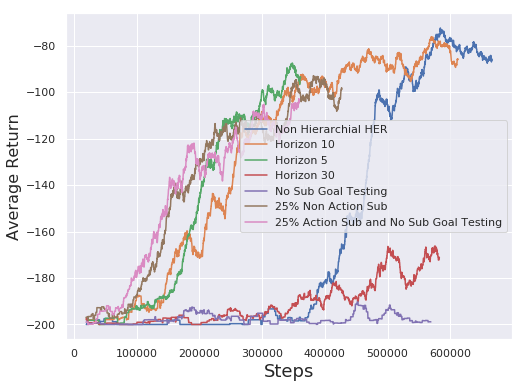

In [202]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
import pandas as pd
df = pd.DataFrame(columns=['steps','returns'])

names = ['Non Hierarchial HER','Horizon 10','Horizon 5','Horizon 30','No Sub Goal Testing','25% Non Action Sub','25% Action Sub and No Sub Goal Testing', 'qualitative performance threshold']
#names = ['Horizon 5','No Sub Goal Testing 25% Non Action Sub2','25% Non Action Sub','25% Action Sub and No Sub Goal Testing']
def movingaverage(interval, window_size):
    window = numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

plt.figure(figsize=(8,6))
final_lines = []
for i in range(0,len(numbs)):
    print(i)
    x = np.array(steps[i])
    data = np.array(numbs[i])
    
    window_width = 100
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    y = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    final_lines.append([x[window_width-1:],y])
    
    plt.plot(x[window_width-1:],y)
    
    
    #plt.xlim(5000,30000)
    df2 = pd.DataFrame({'steps':x[window_width-1:], 'returns': y})
    df = pd.concat([df,df2])
    plt.legend(names)
    
    #plt.savefig('dimensions.pdf')
    plt.xlabel('Steps', fontsize=18)
    plt.ylabel('Average Return', fontsize=16)
    
    
df = df.reset_index()
del df['index']


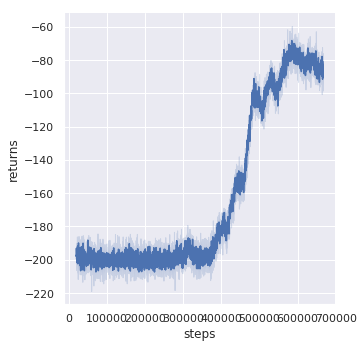

In [210]:
index = 0

x, y  = final_lines[index][0], final_lines[index][1]
df = pd.DataFrame(columns=['steps','returns'])
for i in range(0,3):
    df2 = pd.DataFrame({'steps':x, 'returns': y+(np.random.normal(size = len(y)))*5})
    df = pd.concat([df,df2])
    
df = df.reset_index()
del df['index']

sns.relplot(x="steps", y="returns", kind="line", data=df);

In [209]:
np.random.normal(size=3)

array([-0.09211666, -0.36477399,  0.35209361])

In [129]:
filepath = 'logs/curiositytestlogs'

hierarchy_steps = []
hierarchy_returns = []

normal_steps = []
normal_returns = []
with open(filepath) as fp:
    line = fp.readline()
    cnt = 1
    while line:

        line = fp.readline()
        line = line.split(':')
        if line[0] == 'Frame':
            hierarchy_steps.append(int(line[1].strip('Return')))
            hierarchy_returns.append(int(line[2].replace('\n', '')))
        elif line[0] == 'Test Frame':
            
            
            step = int(line[1].strip('Return'))
            normal_steps.append(step)
            normal_returns.append(int(line[2].replace('\n', '')))
            if step < 50000: # for the smooothing
                normal_steps.append(step+1)
                normal_returns.append(int(line[2].replace('\n', '')))

        
        cnt += 1


KeyboardInterrupt: 

In [130]:

    
steps = [hierarchy_steps, normal_steps]
numbs = [hierarchy_returns, normal_returns]

arrays = ['logs/HER_one_layer_object',]


for i,a in enumerate(arrays):
    event_acc = EventAccumulator(a, size_guidance)
    event_acc.Reload()
    numbs.append([])
    steps.append([])
    print(len(event_acc.scalars.Items('Episode_return')))
    for event in event_acc.scalars.Items('Episode_return'):
        step = event.step
        steps[i+len(steps)-1].append(step)
        proto = event[2]
        
        numbs[i+len(steps)-1].append(proto)

3332


0
1
2


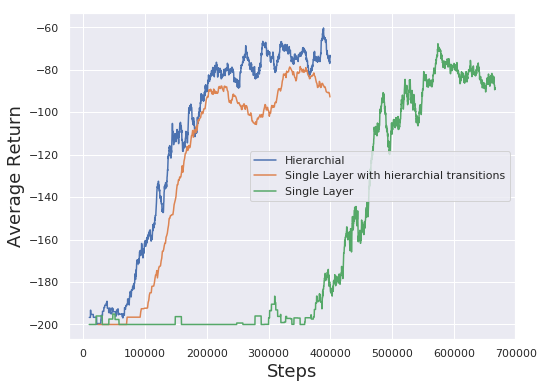

In [150]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

def movingaverage(interval, window_size):
    window = numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')
import seaborn as sns
sns.set()
plt.figure(figsize=(8,6))


for i in range(0,len(numbs)):
    print(i)
    x = np.array(steps[i])
    data = np.array(numbs[i])
    
    window_width = 50
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    
    
    #plt.plot(x[window_width-1:],ma_vec)
    sns.lineplot(x[window_width-1:],ma_vec, ci='sd', err_style='band')
    plt.legend(['Hierarchial', 'Single Layer with hierarchial transitions', 'Single Layer'])
    #plt.savefig('dimensions.pdf')
    plt.xlabel('Steps', fontsize=18)
    plt.ylabel('Average Return', fontsize=18)

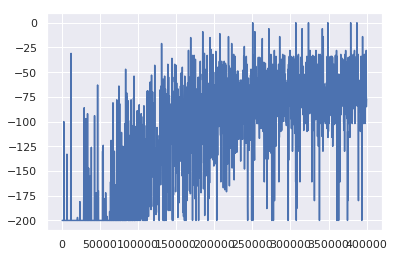

In [149]:


sns.lineplot(hierarchy_steps, hierarchy_returns, ci='sd', err_style='band')

In [151]:
fmri = sns.load_dataset("fmri")

In [89]:
while(1):
    print()

4
6
-2
-3
-4
-8
-3
2
-10
-2
-8
-5
-5
4
-9
4
6
-2
-3
-8
-2
8
9
1
-3
-8
-7
-5
-8
-1
0
-2
-3
6
-1
1
8
-1
2
7
-2
-6
-5
8
-3
-1
1
-10
1
6
5
-6
-5
-7
-8
3
-9
-7
9
4
4
4
9
-7
-9
5
9
8
7
-5
-7
-8
1
-9
3
6
-9
3
-8
-7
5
8
7
-6
-5
7
-6
2
0
1
1
9
-5
5
-10
0
-8
6
1
-6
-5
8
-9
-3
-2
-10
2
-9
-2
8
-1
5
7
8
-1
-8
2
8
-9
-5
4
3
-5
-5
-9
-5
-7
-8
-3
6
3
-1
-6
-10
7
9
1
3
8
-6
-1
2
9
4
8
-4
-8
-5
-9
-7
2
2
-5
4
-4
-10
-6
-1
8
-9
1
8
5
7
4
7
3
6
6
6
-1
4
3
4
-3
-3
6
4
-4
6
0
-8
-7
3
0
-5
1
-2
-9
0
6
9
-6
-8
-5
-4
8
6
-10
8
8
-1
-1
-4
2
-2
5
-2
-3
5
6
-9
7
-6
6
-2
7
9
7
-1
0
5
-7
7
-4
8
6
-8
9
0
-10
-9
-7
-4
9
-10
-9
-9
-6
-2
6
2
8
-5
1
5
4
8
2
-6
-5
-1
-1
7
-5
-10
0
-9
0
2
3
8
9
-6
-8
5
-8
-9
2
-5
-7
-5
-2
-4
7
-5
3
3
1
9
5
-5
0
6
-7
4
-7
5
9
-6
6
7
-10
4
9
8
3
-4
-7
7
-6
2
8
-2
-9
6
-3
3
-7
-3
8
-6
8
7
-9
-4
1
-9
2
0
-5
-3
9
8
1
-3
-1
-1
7
4
3
-2
-2
-4
-10
8
2
7
3
3
1
-9
-10
-10
-8
-9
7
3
-1
1
4
5
1
0
-6
-4
8
-2
-2
8
-2
-5
6
3
4
-7
-5
6
3
-4
1
-6
-8
-8
6
-7
-10
-7
-9
-3
9
6
-10
-3
-3
-3
0
9
4
-8
6
-10
8


-4
0
7
-5
-2
-4
2
-5
-4
5
6
-1
1
5
-9
7
-3
3
5
5
5
0
6
9
-9
-9
6
-6
-4
-2
-7
2
3
-8
-6
-1
-6
1
4
-8
6
-6
9
5
5
-10
-9
-7
-3
9
6
5
7
9
-3
2
-8
-9
1
-6
-5
8
-2
2
3
-4
9
9
7
-8
2
9
-7
-4
3
-5
7
-1
2
-8
5
-9
-1
9
-2
4
5
-1
-8
-5
-1
2
-10
4
-4
-9
-5
4
-4
5
-4
-5
3
7
1
-2
-3
-9
4
0
-4
-5
-9
7
1
8
7
2
1
4
-2
6
5
7
-7
-5
-8
-4
-3
-5
-8
5
7
5
6
-7
2
7
6
-9
5
-7
-8
4
9
-3
-1
2
-7
8
4
-7
-9
-5
-8
4
3
-2
2
-8
-5
2
4
3
6
8
-7
1
5
-4
-7
3
-5
2
-2
3
-1
-3
-9
-5
9
2
9
-9
-5
0
7
9
1
7
4
-4
1
-1
7
-2
-5
-10
-1
3
-9
-2
6
-8
3
-3
-10
2
0
-1
3
4
-4
8
8
6
-9
-2
1
5
-3
7
-7
6
-2
2
6
1
8
-1
1
8
-6
-1
-2
-5
-1
-3
-3
4
3
-9
-6
-6
-5
-1
1
8
5
-4
5
-1
5
1
-2
3
0
-10
-2
-9
7
5
7
-1
1
-10
2
5
5
-5
-10
7
-6
-8
-5
-5
4
-1
4
7
1
-7
0
3
-1
-2
-8
0
9
4
9
8
-9
-5
-7
-9
-6
5
-7
9
2
4
9
-3
1
-6
5
-8
-10
-2
-6
-10
-10
-7
-3
-2
2
-2
-7
-9
5
3
5
-10
8
1
-5
7
-4
-3
4
2
-7
2
-3
2
-8
-1
-7
-2
-4
0
-9
3
-8
1
1
1
9
-4
9
6
-6
-1
4
-6
1
2
-4
2
4
-3
-5
-7
-3
-6
-2
2
6
4
2
3
1
-6
-10
2
8
-4
-3
0
-4
-5
5
5
8
-9
-1
6
-5
-4
3
-1
-7
-8
8


-2
-9
-6
4
8
-4
3
5
7
8
-1
-10
-3
8
-3
9
-9
-10
-2
-6
1
0
-5
-4
-7
-3
-2
-7
1
1
-3
3
3
4
-5
7
-7
-4
2
-9
9
-1
1
-9
-7
1
-10
-3
4
4
4
-2
3
-8
4
-3
1
9
-10
2
2
9
2
-8
4
2
-6
7
7
-5
1
3
6
-7
5
-8
-2
6
4
2
4
3
1
-3
-8
-5
-9
7
9
-7
3
0
-8
4
0
2
3
2
8
-10
5
6
-2
6
2
-10
4
-10
-7
-7
-6
0
9
1
-2
2
-3
8
9
8
1
5
4
8
0
2
9
-9
-3
-3
-5
6
-3
6
7
-5
1
6
-2
5
9
-2
6
-10
4
-3
-2
1
1
-3
-10
1
3
-6
3
-4
-4
-7
-4
-4
-10
4
5
-9
-7
-5
-8
2
-7
1
0
3
-2
-1
-9
-1
-9
-8
-3
9
-7
6
0
-7
2
-2
1
-2
-7
2
-8
4
6
-1
-6
4
-8
7
-1
-6
8
-5
-4
-10
8
-5
5
7
4
6
4
9
3
9
2
5
-5
-10
5
-4
-1
-5
7
3
-6
3
0
9
-3
6
8
-7
7
8
-6
1
5
-6
6
9
9
-6
-2
-3
0
8
-2
8
8
5
1
7
-2
-8
7
-1
7
6
9
6
-3
-8
-7
2
2
-4
-9
2
5
-3
-6
2
-5
-7
2
7
-6
-4
-2
4
1
5
7
-6
3
-8
5
-1
3
-5
-8
0
2
4
-1
4
8
-5
-10
-6
3
-10
9
7
-1
1
9
0
7
-10
0
7
-3
-3
-8
8
6
5
-4
-8
1
-4
3
-5
5
-6
-9
-9
5
2
-4
-9
-9
-1
-10
-3
-2
9
-2
-7
-6
-2
-5
5
-2
0
-9
-9
-8
8
1
-6
-3
3
9
0
-10
3
-7
-5
9
0
4
2
9
3
1
3
0
-1
-7
9
-2
8
-10
-4
-2
6
-9
2
-8
4
-10
3
0
5
-4
-1
1
-9
-9
1
9
2
-4
-2
-8

-4
0
-5
-7
6
-8
-5
4
0
7
2
-10
-8
5
5
1
4
-6
0
-5
-3
0
3
-3
8
-3
-5
1
4
2
-2
2
-6
-10
7
1
1
4
8
-7
-8
0
7
3
3
-3
-1
9
5
5
2
8
6
-3
-7
-3
-5
3
4
-9
0
0
3
2
-9
-9
3
5
-4
1
-7
-5
-6
4
-6
-6
9
-9
-2
4
5
4
-8
4
-1
-1
-1
7
5
-3
-8
6
8
-9
-7
7
3
9
-10
-7
-3
8
4
3
9
5
6
-7
-4
-9
-7
0
-3
7
-7
-3
5
3
6
4
0
-6
-6
3
6
2
-2
-1
-10
3
-3
9
3
-4
2
8
6
7
7
5
-10
-7
9
-3
-6
-2
-2
-3
4
-10
7
-5
7
5
5
-1
4
8
6
9
3
-9
-9
9
-7
4
-3
-6
-5
-9
-5
9
5
-8
5
5
9
-1
-2
8
-3
5
-1
8
4
2
-9
3
1
8
-5
1
-6
-3
-2
-4
3
1
5
-10
-9
1
3
-4
-4
-3
8
4
-2
-6
-4
3
-9
6
1
-10
-9
-6
-6
2
-3
-1
-2
8
-6
0
-1
4
6
5
1
5
4
-6
-6
-9
-1
3
0
-1
0
7
8
3
4
-5
5
4
6
-6
5
4
2
-8
-9
6
-4
2
-9
-3
8
-9
-1
0
-9
2
-8
7
3
3
8
-9
-3
8
9
-2
-9
-3
9
-1
-6
5
9
4
8
-5
7
-8
-7
8
-8
3
2
-10
0
-9
2
-2
0
-4
4
-1
-4
1
-8
-8
-7
3
-3
-6
-9
1
-9
6
-2
1
4
1
-8
-3
-7
5
5
-4
-10
-10
-8
-10
-10
-7
2
-9
0
0
-10
-9
0
-3
7
8
-6
1
5
5
-3
-2
-6
-2
-7
4
9
-6
-6
-2
7
9
-4
0
4
-2
6
4
-8
1
-8
6
-4
7
-5
-5
0
-2
-10
6
-1
0
-10
-3
1
-4
-5
-6
9
5
-10
7
-4
7
-3
-3
-1
-9
-8
-4
-

-2
-10
2
5
2
-2
9
0
-6
6
-8
-8
1
-7
7
-6
-3
-2
-3
-10
-9
9
1
6
-2
-8
-4
1
9
-3
4
-10
0
-6
1
7
2
-3
3
-9
1
-3
-3
-10
9
-2
3
-5
-5
4
5
-4
-1
6
9
-9
2
6
1
-6
1
0
5
8
-8
-2
2
9
-3
6
-1
6
-7
-5
-2
-8
9
-2
8
0
-9
3
1
-5
-1
1
5
8
-10
8
6
-5
-8
-7
1
-3
9
-9
2
3
0
-3
9
-4
-4
7
-1
4
0
1
-5
2
0
2
-10
5
-8
0
3
-6
-7
-2
-9
4
9
0
-6
-4
2
-9
5
6
4
-10
-5
-7
-7
-4
-4
5
5
-6
0
-8
-10
-4
-5
8
-3
-3
1
0
-7
5
2
5
1
2
-1
-5
-5
9
-2
6
0
-1
-4
6
7
-5
-7
-8
-7
5
-3
7
3
-4
9
-5
3
-10
5
-2
5
-10
6
8
4
4
9
-4
-9
-9
-1
-3
7
6
7
6
2
-9
-10
7
-1
8
7
8
-7
-3
9
4
2
7
7
-2
-6
-5
-5
5
0
-3
1
2
7
0
2
-5
-2
9
-1
9
-9
-4
0
0
-9
-3
-6
5
-1
-8
-6
4
2
-10
5
-1
1
7
-3
3
-6
-5
1
0
-6
-6
9
-4
4
-6
-5
-4
7
4
5
5
-5
6
5
1
-1
-1
1
9
7
1
-4
1
-1
-1
4
8
4
0
0
8
6
-5
-2
-2
2
-2
-9
-1
8
-8
-6
-5
6
-3
-4
4
-2
-3
1
2
-9
-2
7
-10
3
-2
7
-4
9
7
6
-3
3
1
-4
-7
4
7
-3
-8
-4
-6
-9
-7
1
-1
-1
-1
-2
4
0
-1
2
1
-1
-7
-9
1
4
-6
-1
-9
-10
-5
-3
1
9
3
-4
8
8
-9
-8
-6
0
9
-10
9
0
-5
-4
9
0
7
-6
-3
-9
-9
2
2
8
1
-9
-7
2
-2
-6
-2
-1
-9
-6
5
-5
0
1
-1

9
3
8
-6
-9
-9
-2
-6
5
0
0
3
-7
-5
7
-6
-3
4
8
-3
-3
4
9
-10
-8
3
-5
-9
-5
6
0
7
-5
-6
-1
-6
1
-6
-6
7
0
9
5
1
-2
3
-3
2
8
0
-9
5
4
1
1
3
-2
-5
8
-9
-10
1
-10
-9
8
-6
1
3
6
-9
-8
-10
2
-3
-4
5
-5
4
6
-4
2
1
-4
-8
-3
9
-4
-3
3
-4
0
8
-5
-8
8
7
7
9
6
8
9
2
-5
1
0
9
3
-2
3
-10
6
-8
-8
-9
-7
-4
1
0
9
-6
-7
-4
3
2
-4
0
-7
0
2
-3
-5
-4
4
-5
-9
3
4
3
4
5
1
6
-6
-10
-8
-3
-1
-4
-6
-2
8
-2
-6
2
-10
9
-1
-2
6
1
-3
-2
9
-1
-4
9
7
-6
-3
-8
2
-6
9
1
2
7
2
-3
1
3
9
1
-10
5
0
-7
-1
-8
3
-5
3
-9
-1
-8
-6
-3
1
4
3
6
-4
-10
-1
3
-5
4
-3
9
9
-10
-9
6
-8
-3
2
-8
9
3
9
1
-8
-8
6
-8
4
-8
-8
-10
4
-1
-1
-3
0
6
6
5
9
-4
-1
-1
5
-5
9
5
0
-5
-5
2
-5
-10
-9
6
-6
9
-4
0
-10
-7
9
-1
7
5
-4
6
2
2
-1
-6
1
0
4
-9
6
5
0
-2
1
6
-10
-1
7
9
-7
-6
4
-2
3
-2
0
-3
-5
7
-8
-9
0
1
4
-6
-5
-10
0
8
6
-4
-6
-5
-2
7
-2
9
6
-9
-7
4
8
-9
9
1
4
2
-8
7
-8
3
-5
-8
3
-5
4
6
2
-9
7
0
-7
-9
6
-5
7
8
-5
3
9
9
6
-5
9
-10
5
-9
-10
-6
7
-6
-2
-1
4
0
6
4
2
5
8
-8
4
1
2
-1
-5
-3
-9
3
-10
2
-4
-10
-9
5
3
2
3
-5
-9
9
-3
-10
5
4
2
-8
4
-8
8
0
-3


-4
3
-7
-5
7
-10
-1
-8
-5
3
5
9
3
-5
-1
7
-6
-1
2
3
-5
7
-10
0
-5
1
-2
-2
-7
8
2
2
-2
3
-10
9
-1
-8
-8
6
2
7
1
3
5
6
1
-1
5
5
-3
7
-9
9
-8
9
-4
7
-2
3
0
-7
-3
-9
-8
-1
-3
-1
-9
7
-6
-6
4
2
-5
-8
9
4
7
-7
-7
-5
-3
9
3
5
-9
7
9
2
-2
-9
-7
-7
3
-3
-6
-8
-6
-8
5
9
9
-9
2
1
-3
1
4
3
-9
1
7
0
-2
4
0
-10
9
9
-2
1
0
0
-1
-5
-4
-7
9
8
1
-4
-2
-5
-8
9
7
4
2
4
1
0
-6
-9
-2
-8
-7
0
7
6
-9
3
-3
-1
-8
2
3
8
0
6
-3
8
-1
6
4
9
3
3
-9
-2
-6
3
-2
7
-1
5
-8
-3
-6
-1
-4
-8
-5
8
7
7
-1
-5
-2
4
6
9
7
-3
-8
-5
4
1
1
7
2
5
0
5
2
-3
-8
-8
-6
0
-4
4
-3
7
0
5
0
-4
-7
2
0
-9
8
9
7
4
3
6
-1
-6
-5
6
-3
6
-5
8
-8
-3
-1
-5
1
-7
1
-9
-10
4
4
-9
-1
-8
-6
-5
-7
1
-4
2
-10
-8
-3
3
-8
-6
8
-6
-5
7
4
9
0
-7
5
9
9
0
-10
9
8
8
-1
0
2
-4
6
-7
7
-3
-2
-8
-4
-1
6
1
5
1
-6
7
6
3
4
-8
8
-6
4
-2
9
-1
-3
2
8
0
-5
6
2
5
-3
3
7
8
-1
-4
-7
-4
8
-5
0
2
7
6
7
-5
-6
-3
-5
1
-8
-9
-3
-2
-3
1
-5
-4
-5
5
2
-9
-6
0
7
-2
-2
9
8
-8
7
4
6
-10
2
4
7
4
4
-2
-1
-8
-4
-2
8
-4
-2
6
7
6
-10
-7
2
-6
7
6
-1
-5
4
5
-3
-7
1
4
-6
-3
-6
-2
9
-1
1
-2
1
-10


-1
9
-6
-3
6
4
3
-5
-7
-10
2
5
6
5
-5
-10
-2
-7
6
-5
-6
-9
-1
-4
4
-6
6
1
7
0
8
0
8
-1
-4
9
-8
6
-1
-8
9
-4
7
-2
7
-9
3
-8
7
0
-1
-9
3
3
-2
7
-5
6
7
-7
-1
8
1
2
-1
-7
-7
-9
-2
9
-3
-3
-2
-2
3
-9
-4
2
-5
9
6
0
1
-4
-3
-9
2
-5
1
-8
-4
7
8
8
-6
9
2
5
6
-3
-9
7
-8
-3
3
3
-3
8
5
-9
0
6
-5
-6
-3
-4
5
-9
-5
9
8
-10
-6
2
-4
1
-10
-3
9
-3
-7
-10
-6
6
-10
4
4
4
3
0
8
-9
-4
-2
-2
-10
7
-6
-1
-4
-9
1
3
-6
-7
-8
-1
0
-9
2
-4
-7
-9
-3
-9
6
1
-6
-5
-10
-9
4
-4
-8
3
-1
-5
-3
4
-4
2
-1
-9
-10
3
-10
8
0
2
1
7
-3
-3
-4
2
-4
-3
4
-10
9
-10
9
2
7
-10
4
3
-8
-5
8
2
-2
-4
-10
6
-6
-3
-6
0
7
-9
-3
0
-7
-7
-6
9
-1
7
-7
2
-6
-8
-3
-6
-1
-9
-9
7
5
-2
4
-9
-2
9
4
8
-7
-1
9
4
-7
-5
-9
-7
-8
5
-5
3
-10
9
-3
-3
-5
2
5
-8
2
-6
-6
3
-8
-10
3
8
6
-9
-8
9
1
4
5
-2
-2
-5
6
-4
5
-6
-8
-8
7
4
-10
-8
3
-6
2
-8
-5
1
9
7
7
0
-5
9
9
-4
-9
9
9
6
-6
2
2
4
0
-9
6
-9
1
-1
6
-3
-10
-10
6
2
-2
-9
0
-7
3
9
2
7
7
-5
-8
7
8
3
-3
1
3
5
-6
6
-5
-10
-5
-9
-3
6
-3
-9
-6
6
-3
-3
7
-4
-2
-6
0
-3
9
1
-6
0
6
7
-8
-7
0
3
3
-7
4
-7
-7
9
-6
9
8
-

3
9
-5
2
1
4
-3
3
-9
6
7
-2
-10
8
-1
-1
2
-1
-6
-4
-6
1
-1
-6
-10
7
-6
-5
3
9
-6
-10
-9
-4
-5
-6
5
3
0
-8
-2
3
-8
1
-2
-8
-3
9
-3
-10
-8
-6
7
-9
-3
-10
-1
-10
9
7
-3
-7
2
-9
7
-8
-4
-9
7
1
-1
4
-2
-8
-4
6
-3
-8
-4
1
8
-5
0
6
-5
3
2
7
-3
-7
-2
3
6
-3
4
4
-10
5
5
-8
3
0
-6
8
0
-1
1
2
0
0
-7
3
-5
-4
-9
-5
8
2
3
9
5
4
7
0
-1
6
-7
-1
-6
-2
-5
-3
-5
-5
7
-1
-9
9
-8
4
-1
-5
5
-1
8
-3
-8
2
-9
4
-8
-4
-4
-6
8
9
-4
-3
4
9
4
-9
-2
-4
-6
8
7
-10
3
9
-7
-5
7
9
-5
-7
-7
7
-3
0
-3
9
-6
5
6
7
-9
4
-5
-10
0
-9
2
3
-10
-1
-5
-10
9
3
4
2
0
-3
5
9
2
4
-8
7
1
7
0
0
-7
6
7
-7
-7
2
7
-3
-10
-7
-5
6
5
8
4
-6
6
1
-5
1
-8
-3
7
6
-7
2
4
-6
9
5
-10
-6
2
-9
-9
-6
-8
-5
-4
3
-10
-7
-7
-4
5
0
-1
-5
-6
8
-5
-9
-3
5
-10
-2
9
-5
-3
7
-2
-7
-6
-8
5
-3
-5
1
5
-5
-10
9
7
0
3
6
2
8
8
-1
-4
-9
0
-7
-2
3
-1
7
-1
-4
2
-2
-3
9
3
-2
7
0
1
0
-3
-8
-3
4
9
-8
8
5
-3
-7
9
5
1
-2
6
6
4
1
-1
9
8
3
2
-8
7
-2
3
0
5
2
-3
5
6
3
4
-5
-10
-4
-10
-6
0
-1
5
2
-9
-3
-10
1
-4
6
5
1
4
-7
8
-10
6
-4
-2
-10
-9
7
-6
-8
-2
-8
-4
0
1
-8
-3
6
7
-6
-5

5
1
5
-8
-2
5
8
4
3
-2
6
-3
0
-6
1
-2
1
9
-8
-6
-4
-3
3
-9
-8
7
-9
-2
-1
9
5
-10
-5
3
4
0
-9
5
-4
3
7
-5
9
2
-10
5
-7
0
2
1
-5
-7
-3
0
-3
5
-3
-5
1
-3
8
1
-2
-10
-6
-1
-8
1
5
-8
2
-7
-10
4
-1
-5
4
9
-2
8
0
1
5
8
-5
4
-10
-1
-2
1
-2
-4
3
-2
-5
1
-6
1
2
-7
-1
-5
-8
-5
-6
3
7
7
1
-2
-9
-8
-6
7
8
2
-2
7
8
-10
-6
-8
-3
-10
-3
0
6
5
-4
7
-10
-3
-4
2
-7
-10
6
4
-7
-10
2
-5
-3
5
-7
-10
0
3
8
-10
-5
5
-1
-1
7
9
3
0
-9
-6
0
8
-2
-1
9
9
2
-7
-8
6
0
7
8
2
-7
-7
-1
-6
-7
6
-10
-7
-2
5
-1
9
-2
8
-1
-6
8
6
-5
-2
-8
4
9
0
8
-5
8
-8
-8
6
-7
-2
6
-10
-7
9
4
-9
-1
-10
5
7
-5
-6
3
5
1
9
-5
9
-4
3
9
9
-8
4
-8
-10
8
-10
-8
8
-3
3
7
-8
-9
7
-7
0
-2
-10
9
1
2
-5
-6
-9
-2
-5
5
-9
6
7
-2
-3
8
1
-10
1
3
-3
5
6
-10
8
-8
-7
8
8
-10
2
-9
6
-5
-8
6
-1
-6
-4
-8
-2
-1
6
4
3
-9
0
2
-8
9
-6
-2
8
1
2
9
7
1
1
-4
-2
8
-6
-7
-10
0
-6
-10
0
8
-10
-1
9
-2
-5
1
0
8
6
-1
9
8
6
3
-4
-8
-7
4
-6
-5
7
9
-5
-4
8
7
8
3
-3
4
-9
2
-3
-1
-1
-7
2
-10
1
-8
9
4
7
-1
5
-8
6
-4
4
2
9
8
5
3
-4
-2
-9
6
-1
4
-7
9
-6
-2
-8
9
6
-8
-6
-10
5
-2
-1


-4
-9
-10
-10
-6
-2
1
-4
-7
-5
-2
2
1
5
1
4
-10
1
-1
3
8
-9
0
1
9
-4
-1
1
-5
-3
-2
5
-1
4
-9
-9
2
2
2
5
-9
-4
-5
-4
1
-5
-7
-5
-1
6
8
-8
-10
-7
-7
7
-4
3
6
-2
-2
-4
2
1
-5
8
-6
0
-5
-1
-9
-3
3
9
-6
7
7
9
-7
7
-10
6
0
-3
5
-3
-2
2
-10
-3
4
7
8
-10
1
-7
-6
3
6
7
6
1
-6
8
7
-1
1
-7
-9
1
-6
-2
-5
6
-6
7
3
-6
1
5
1
-6
2
1
3
-10
-10
-3
-9
6
-8
-9
-6
6
-5
9
8
-9
4
-10
-4
1
3
4
6
8
5
4
1
1
9
-6
-2
9
-5
-1
6
-6
9
5
9
4
-4
-2
9
-7
9
-3
4
-9
-3
2
2
-7
-8
1
-6
2
-5
-7
7
-8
-7
-6
-5
-2
9
-10
-6
5
1
8
7
7
-10
2
0
4
-5
-8
3
-6
-5
-1
-5
-1
-7
-4
2
7
8
1
-4
0
-9
-1
-4
-9
-9
8
6
-2
-7
6
3
0
-1
-10
7
0
7
6
0
-1
1
-1
2
-9
-7
9
-10
-5
-5
-8
-5
6
0
9
-6
4
2
-9
-2
9
-3
-7
-7
6
1
-7
7
2
-8
4
-6
-8
3
-9
8
1
-4
-6
-3
-7
-7
9
9
8
-5
6
-5
-6
2
2
-8
8
-10
0
1
-6
-2
2
5
2
6
-6
5
8
-2
6
-8
-3
5
-10
3
-8
-5
0
7
0
-9
-2
-7
5
3
3
2
-6
-9
0
1
-5
-2
2
3
-6
-1
-8
-5
2
9
8
-9
5
2
2
-6
0
-1
8
-5
2
2
2
-2
-1
-5
-7
4
-5
2
-9
-10
-8
9
4
-6
-3
7
-1
8
1
-2
5
1
2
4
-9
-8
-1
8
7
3
-6
9
0
6
3
4
5
6
1
-8
9
1
-10
-6
-1
4
9
-8
1
-9
-6

-1
-1
5
-8
1
7
0
6
-1
-10
-3
-4
6
0
-4
-5
-10
-1
-3
1
-2
8
-6
7
-7
4
3
6
-3
2
9
-5
5
-2
-7
8
-8
-10
-5
8
8
-1
8
-3
-8
-2
8
-4
8
8
4
-4
9
3
5
3
6
-7
9
4
4
-7
6
5
-5
-1
-8
1
-2
6
7
-6
-6
8
-6
-1
0
5
-3
-6
8
-4
-5
6
1
6
0
-6
-3
-1
-9
-6
-7
8
-8
2
7
5
-9
-7
-3
5
0
-7
9
8
-3
2
4
1
0
2
4
-9
0
0
-5
2
2
-4
-5
-6
-5
-7
6
2
-8
-1
9
-8
-7
-8
4
-5
6
-7
-9
-3
-8
7
7
2
-6
-7
-8
-5
9
6
5
-6
7
-6
6
8
-1
0
6
9
-5
-8
-7
4
-3
7
-7
-3
1
-8
-5
-10
9
-2
-9
-3
1
5
9
7
-5
-2
4
9
5
5
0
0
-3
-3
5
1
6
-4
-10
0
-10
-8
6
1
8
4
3
-10
-8
-3
4
8
3
9
-3
8
1
-10
-2
-1
9
4
-6
5
-5
0
-1
-4
2
-4
-8
9
-9
-4
6
2
-1
-2
6
2
-7
2
-1
-6
-4
-5
-3
-3
7
-2
7
9
-8
-4
2
8
5
1
-4
7
-6
3
-5
-2
3
6
9
7
-7
-4
3
8
5
-2
-2
-1
-3
-2
4
6
-5
-3
-2
-10
7
-3
6
-6
3
-3
-6
-5
4
6
-3
-6
-3
-7
4
1
0
-9
2
-8
1
0
3
5
-3
0
7
-7
1
-7
-4
-5
4
-10
9
-8
1
-1
-10
9
-8
-4
-1
8
0
4
6
-7
-7
8
-3
7
-10
0
2
-10
-9
5
2
1
3
-2
-8
8
2
3
-9
-6
-4
-7
5
4
-4
6
8
1
7
1
8
2
5
-1
-6
3
-10
1
7
5
7
9
-10
-10
4
4
5
-3
6
-1
-5
9
7
-3
-10
1
1
-3
3
-9
2
0
2
-1
-6
4
2
0
7
5
-

7
-6
-7
9
3
-10
5
-10
-9
-8
2
-5
-5
1
-8
-4
3
-6
-3
7
-4
-9
-1
4
-2
0
5
-8
-1
-7
8
-4
-5
-9
-3
-2
-3
-6
6
-2
0
-5
-1
4
-1
9
-8
2
-10
2
0
7
8
5
-6
6
5
7
-6
-3
-2
3
3
1
-2
3
5
3
-3
8
7
1
-9
4
-10
6
-4
3
3
-4
5
2
-10
-9
-10
1
3
-4
1
5
3
2
-3
-3
-6
-2
-10
-9
-9
-9
-7
0
8
4
6
-9
7
-5
9
7
5
-7
0
-5
7
-8
0
-8
5
-5
-6
5
7
1
8
4
7
1
0
-1
-2
-6
-8
4
6
9
2
-10
-6
-9
-4
-1
6
7
-3
-5
-3
4
6
8
9
-4
0
5
-2
-8
8
-6
-4
9
8
-8
0
4
-4
7
1
8
3
2
9
8
9
-10
-9
9
-5
-1
5
-7
-3
0
-3
-2
-7
-4
-5
-7
4
7
-2
5
-4
2
-6
-4
8
5
6
7
1
-5
-10
-7
-10
-4
7
-7
7
3
-7
-5
5
-5
-7
6
-7
1
-3
0
9
5
8
0
-8
5
-10
3
7
9
-3
8
0
8
-5
4
9
-7
6
-9
-10
6
7
5
-1
1
-4
4
2
2
-10
-7
3
-3
8
-9
-9
9
-7
0
-6
3
-8
7
-8
-7
3
-6
3
9
-9
4
0
8
6
-2
-4
-2
8
-7
8
0
9
-7
4
-9
3
-4
-2
7
-8
1
4
-9
-5
-6
-10
-5
6
-8
-4
-7
-8
3
-1
-7
-8
7
1
3
-2
4
-9
-7
9
-8
-8
1
8
4
8
-1
6
-10
-2
-4
6
8
1
-2
-3
-1
-3
-1
1
6
4
-1
-4
-1
7
-3
-7
6
-1
0
-9
-10
-4
6
0
4
-7
-3
-1
-4
7
4
-6
6
-4
-1
-7
-10
7
-8
2
3
9
-3
-8
5
0
7
6
-10
3
7
9
9
5
-8
-6
2
7
-5
7
8
2
8
1
-2
-7
-1

KeyboardInterrupt: 